# DEM raster data analysis in Python using rasterio , richDEM , geopandas , and shapely

参考：https://www.youtube.com/watch?v=6wqFzbiU8uY


Slopeは0-90度の角度で傾斜を表し、aspectは0-360度の範囲で方向を示す。

例えば、Slope:75, aspect:180 の場合は、真南に75度の急な傾斜がある、ということを表している。

In [1]:
!pip install richdem

     |████████████████████████████████| 329 kB 26.4 MB/s eta 0:00:01
  Created wheel for richdem: filename=richdem-0.3.4-cp38-cp38-linux_x86_64.whl size=7985808 sha256=0e9272fd3b1b73c4e491c2ba726375237bf54dcb1cb69546afb9d2743d5e570a
  Stored in directory: /root/.cache/pip/wheels/9f/9c/61/8da642da1b65cbf887fa5d335778dfcefe22fba629e6b055d4
Successfully built richdem


In [3]:
import rasterio
from rasterio import plot

import richdem as rd

import geopandas as gpd

from shapely.geometry import Point

ファイルの読み込み

In [4]:
dem_sample = rasterio.open('./dem_sample.tif')
dem_sample

<open DatasetReader name='./dem_sample.tif' mode='r'>

In [7]:
# CRSとバンド数を表示
dem_sample.crs, dem_sample.count

(CRS.from_epsg(4326), 1)

DEMデータはバンド数は１になる

In [9]:
# bboxの数値を表示
dem_sample.bounds

BoundingBox(left=38.99986111111111, bottom=23.999861111111112, right=40.000138888888884, top=25.00013888888889)

In [37]:
# 高さと幅を表示
raster_width = dem_sample.width
raster_height = dem_sample.height

raster_width, raster_height

(3601, 3601)

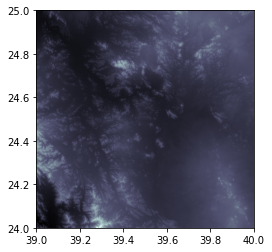

<AxesSubplot:>

In [11]:
# 可視化
rasterio.plot.show(dem_sample, cmap='bone')

バンド１のデータを抽出する

In [17]:
# バンド１の数値を得る
# その際intで取得されるので今後の計算のためにfloatに変換しておく
dem_band1 = dem_sample.read(1).astype(float)
dem_band1

array([[ 443.,  443.,  442., ..., 1052., 1049., 1039.],
       [ 442.,  443.,  443., ..., 1064., 1055., 1044.],
       [ 443.,  443.,  443., ..., 1063., 1052., 1042.],
       ...,
       [ 549.,  558.,  573., ...,  960.,  959.,  958.],
       [ 566.,  574.,  589., ...,  960.,  959.,  958.],
       [ 571.,  584.,  611., ...,  959.,  958.,  959.]])

In [16]:
# ちなみにバンドは１つしかないので以下はエラーになる
dem_sample.read(2)

IndexError: band index 2 out of range (not in (1,))

In [24]:
# row, colを指定してそのピクセルの値を取得
dem_band1[1,5]

440.0

In [25]:
# そのピクセルの緯度経度を知りたい場合は、バンドデータではなく、大元のDEMデータで指定する必要がある
dem_sample.xy(1,5)

(39.00138888888889, 24.999722222222225)

richdemのオブジェクトを生成する

In [27]:
richdem_sample = rd.rdarray(dem_band1, no_data=-9999)
richdem_sample

rdarray([[ 443.,  443.,  442., ..., 1052., 1049., 1039.],
         [ 442.,  443.,  443., ..., 1064., 1055., 1044.],
         [ 443.,  443.,  443., ..., 1063., 1052., 1042.],
         ...,
         [ 549.,  558.,  573., ...,  960.,  959.,  958.],
         [ 566.,  574.,  589., ...,  960.,  959.,  958.],
         [ 571.,  584.,  611., ...,  959.,  958.,  959.]])

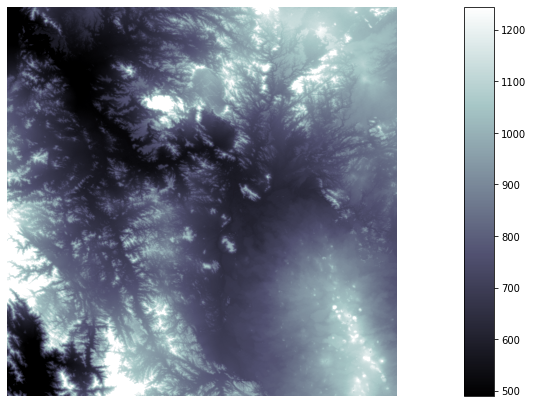

{'vmin': 490.0, 'vmax': 1245.0}

In [28]:
# plot the richdem object
rd.rdShow(richdem_sample, axes=False, cmap='bone', figsize=(9,6))

vminはminimum elevation, vmaxはmax elevationを表している

→白いところが高い、黒いところが低い

傾斜情報を生成する

In [29]:
rd_slope = rd.TerrainAttribute(richdem_sample, attrib='slope_degrees')
rd_slope

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A

rdarray([[14.036243, 10.024988, 29.205933, ..., 81.046036, 81.08339 ,
          79.78765 ],
         [26.565052, 10.024988, 21.568129, ..., 82.89726 , 84.04198 ,
          77.51774 ],
         [14.036243, 10.024988,  0.      , ..., 83.72314 , 84.6876  ,
          79.44686 ],
         ...,
         [84.50995 , 86.46011 , 86.762955, ...,  0.      , 45.86825 ,
          32.512516],
         [83.88498 , 87.082695, 87.703476, ..., 27.938353, 38.32882 ,
          21.568129],
         [74.9887  , 85.769745, 86.90326 , ..., 27.938353, 29.205933,
          19.47122 ]], dtype=float32)

 Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.825455======================= ] (99% - 0.0s - 1 threads)


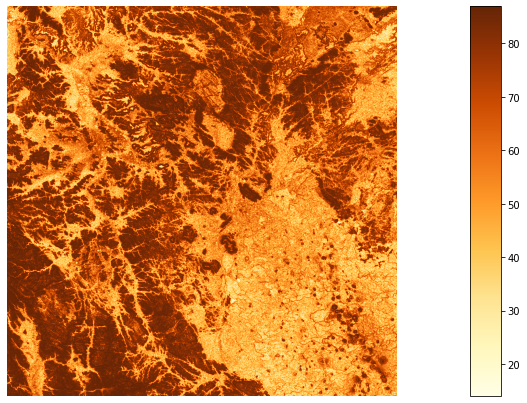

{'vmin': 14.036243438720703, 'vmax': 86.9437255859375}

In [30]:
# plot slope values
rd.rdShow(rd_slope, axes=False, cmap='YlOrBr', figsize=(9,6))

傾斜が急な部分ほど黒色になる

方向情報を生成する

In [31]:
rd_aspect = rd.TerrainAttribute(richdem_sample, attrib='aspect')
rd_aspect

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.10092======================== ] (99% - 0.0s - 1 threads)


rdarray([[180.      , 135.      ,  26.565052, ...,  32.125   ,
           64.44003 ,  54.162346],
         [270.      , 315.      ,  18.434948, ...,  52.594643,
           74.87599 ,  75.57922 ],
         [  0.      , 315.      , 270.      , ..., 108.43495 ,
          109.69862 , 117.75854 ],
         ...,
         [324.7824  , 309.35175 , 303.4654  , ..., 270.      ,
          104.03625 , 101.30993 ],
         [339.62357 , 315.51617 , 316.62497 , ..., 135.      ,
          108.43495 ,  71.56505 ],
         [283.57043 , 287.76486 , 305.08725 , ..., 135.      ,
          153.43495 , 315.      ]], dtype=float32)

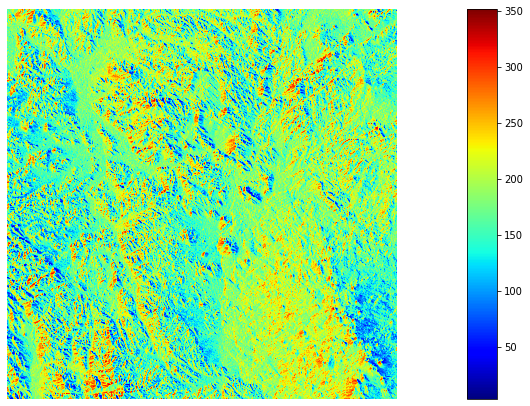

{'vmin': 3.6522228717803955, 'vmax': 351.5730285644531}

In [32]:
# plot aspect values
rd.rdShow(rd_aspect, axes=False, cmap='jet', figsize=(9,6))

青色は北から東にかけての傾斜方向、オレンジ色は南から西にかけての傾斜方向になる

In [33]:
pnt_data = {"elevation":[], "slope":[], "aspect":[], "geometry":[]}

In [34]:
richdem_sample.shape

(3601, 3601)

In [38]:
# 本来は、3601*3601のデータについて、それぞれ上記の属性値を当てはめていく
# ただここでは時間がかかるので下記にしている
width_step = 7
height_step = 200

for i in range(0,raster_width,width_step):
    if i % 47 == 0 and i != 0:
        for j in range(200,raster_height-height_step,height_step):
            pnt_data['elevation'].append(round(richdem_sample[i,j],2))
            pnt_data['slope'].append(round(rd_slope[i,j],2))
            pnt_data['aspect'].append(round(rd_aspect[i,j],2))
            pnt_data['geometry'].append(Point(dem_sample.xy(i,j)))

In [42]:
dem_sample.crs

CRS.from_epsg(4326)

In [40]:
# CRS情報を付与して、geopandasのデータフレームを生成
gp_df = gpd.GeoDataFrame(pnt_data, crs="EPSG:4326")
gp_df

,elevation,slope,aspect,geometry
0,520.0,67.900002,203.960007,POINT (39.05556 24.90861)
1,518.0,85.239998,268.809998,POINT (39.11111 24.90861)
2,560.0,71.230003,347.739990,POINT (39.16667 24.90861)
3,546.0,62.880001,219.809998,POINT (39.22222 24.90861)
4,552.0,56.310001,270.000000,POINT (39.27778 24.90861)
...,...,...,...,...
165,822.0,62.880001,230.190002,POINT (39.72222 24.08611)
166,929.0,56.669998,260.540009,POINT (39.77778 24.08611)
167,1030.0,32.509998,168.690002,POINT (39.83333 24.08611)
168,1077.0,60.630001,140.710007,POINT (39.88889 24.08611)


In [43]:
# geojson形式で出力する方法
gp_df.to_file('./random_pnts.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [44]:
# shapefile形式で保存する方法
gp_df.to_file('./random_pnts.shp', driver="ESRI Shapefile")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Processing DEMs with GDAL in Python

参考: https://www.youtube.com/watch?v=5dDZeEXws9Q

In [53]:
import os
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt

In [69]:
cmd = 'gdaldem slope dem_sample.tif slope1.tif -compute_edges'

In [70]:
os.system(cmd)
# subprocess.call(cmd.split())

0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [71]:
slp1 = gdal.Open('slope1.tif')
slp1

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f5f78132090> >

In [72]:
slp1Array = slp1.GetRasterBand(1).ReadAsArray()
slp1Array

array([[89.97878 , 89.96817 , 89.982346, ..., 89.998566, 89.99837 ,
        89.9978  ],
       [89.96817 , 89.909966, 89.95974 , ..., 89.99802 , 89.99834 ,
        89.9985  ],
       [89.97153 , 89.909966,  0.      , ..., 89.99825 , 89.99852 ,
        89.998474],
       ...,
       [89.99896 , 89.999016, 89.9991  , ...,  0.      , 89.98456 ,
        89.98727 ],
       [89.9989  , 89.99919 , 89.99936 , ..., 89.969986, 89.979866,
        89.97749 ],
       [89.99824 , 89.99931 , 89.99945 , ..., 89.98576 , 89.96817 ,
        89.97749 ]], dtype=float32)

In [73]:
type(slp1Array)

numpy.ndarray

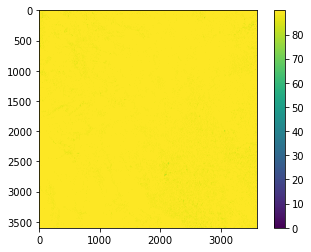

In [74]:
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

ほぼ89のデータばかりなので上記の結果になっている

In [60]:
import pandas as pd
slp1df = pd.DataFrame(slp1Array)

In [62]:
slp1df.describe()

,0,1,2,3,4,5,6,7,8,9,...,3591,3592,3593,3594,3595,3596,3597,3598,3599,3600
count,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,...,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000
mean,89.268639,89.742218,89.742851,89.792297,89.642342,89.767532,89.766991,89.692123,89.767563,89.667259,...,89.483795,89.383415,89.159157,89.384338,89.559570,89.409637,89.509773,89.509460,89.508965,88.237312
std,8.044570,4.736429,4.736458,4.237579,5.601096,4.494013,4.493991,5.187045,4.494013,5.398101,...,6.688346,7.322586,8.575738,7.322659,6.168990,7.169508,6.519974,6.519952,6.519918,12.425472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,89.991852,89.990509,89.990997,89.990509,89.990997,89.990997,89.991043,89.990509,89.990456,89.990234,...,89.979866,89.978783,89.979866,89.979866,89.981995,89.981995,89.981995,89.981995,89.979866,89.982346
50%,89.997742,89.997734,89.997726,89.997696,89.997734,89.997742,89.997818,89.997856,89.997879,89.997925,...,89.988182,89.987633,89.988472,89.988472,89.988831,89.988831,89.988831,89.988747,89.988472,89.989532
75%,89.998833,89.998810,89.998795,89.998787,89.998779,89.998802,89.998825,89.998848,89.998856,89.998848,...,89.993073,89.993073,89.993156,89.993256,89.993256,89.993378,89.993286,89.993378,89.993378,89.993759
max,89.999794,89.999817,89.999649,89.999603,89.999672,89.999695,89.999641,89.999649,89.999588,89.999489,...,89.998947,89.998962,89.999084,89.999115,89.999092,89.999130,89.999168,89.999214,89.999214,89.999199


In [80]:
dem = gdal.Open('dem_sample.tif')
slp2 = gdal.DEMProcessing("slope2.tif", dem, 'slope', computeEdges = True)

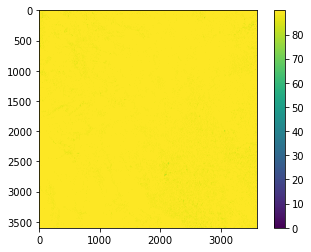

In [81]:
slp2Array = slp2.GetRasterBand(1).ReadAsArray()
slp2Array
plt.figure()
plt.imshow(slp2Array)
plt.colorbar()
plt.show()

In [83]:
(slp1Array == slp2Array).all()

True

gdalを使ってDEMを扱えるけど、richdemの方が扱いやすいらしい

In [84]:
import richdem as rd

In [86]:
dem = rd.LoadGDAL('dem_sample.tif')
dem

rdarray([[ 443,  443,  442, ..., 1052, 1049, 1039],
         [ 442,  443,  443, ..., 1064, 1055, 1044],
         [ 443,  443,  443, ..., 1063, 1052, 1042],
         ...,
         [ 549,  558,  573, ...,  960,  959,  958],
         [ 566,  574,  589, ...,  960,  959,  958],
         [ 571,  584,  611, ...,  959,  958,  959]], dtype=int16)

In [87]:
slope = rd.TerrainAttribute(dem, attrib='slope_degrees')
slope


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.652817======================= ] (99% - 0.0s - 1 threads)


rdarray([[89.93634 , 89.909966, 89.97153 , ..., 89.99749 , 89.997505,
          89.99713 ],
         [89.96817 , 89.909966, 89.95974 , ..., 89.99802 , 89.99834 ,
          89.996475],
         [89.93634 , 89.909966,  0.      , ..., 89.99825 , 89.99852 ,
          89.99703 ],
         ...,
         [89.99847 , 89.999016, 89.9991  , ...,  0.      , 89.98456 ,
          89.97503 ],
         [89.9983  , 89.99919 , 89.99936 , ..., 89.969986, 89.979866,
          89.95974 ],
         [89.995735, 89.998825, 89.99914 , ..., 89.969986, 89.97153 ,
          89.95499 ]], dtype=float32)

# 参考X：Digital Elevation Model (DEM) in Python

https://medium.com/spatial-data-science/digital-elevation-model-dem-in-python-758f0ede3af8



In [1]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt

# 以下は、DEM関係なく、ラスターデータの扱い方についての内容になっている

参考：https://github.com/geohackweek/raster-2019

## ラスターデータとベクターデータ

- ベクターデータ：地表の特定の機能を表し、属性を割り当てたデータ（点や線、ポリゴンで表現される）
- ラスターデータ：ピクセルとして表現される値をグリッド状に格納したデータ


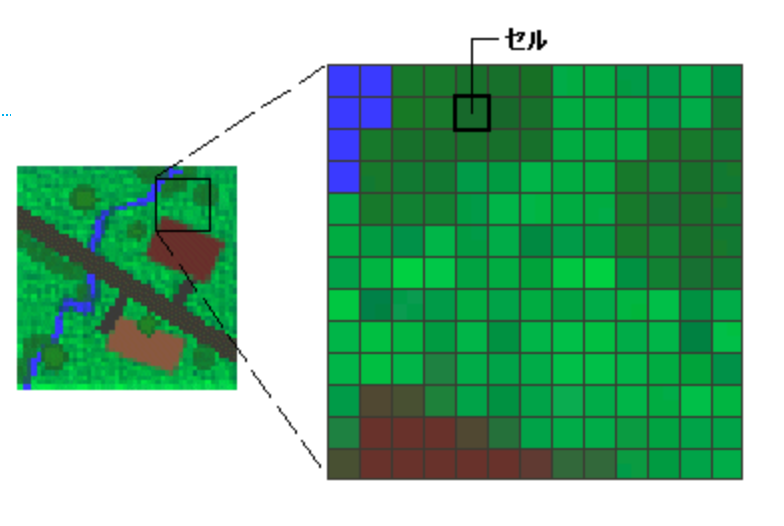

参考：[ラスターデータ - esriジャパン](https://www.esrij.com/gis-guide/gis-datamodel/raster-data/#:~:text=%E3%83%A9%E3%82%B9%E3%82%BF%E3%83%BC%20%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AF%E3%80%81%E8%A1%8C%E3%81%A8,%E3%81%8C%E3%82%8F%E3%81%8B%E3%82%8B%E3%81%A8%E6%80%9D%E3%81%84%E3%81%BE%E3%81%99%E3%80%82)

## ラスターデータの例

- ALOSやSentinelなどの衛星画像
- DEM（数値標高モデル）のデータ
- LiDARデータ
- 土地被覆マップ

など

LiDARとは

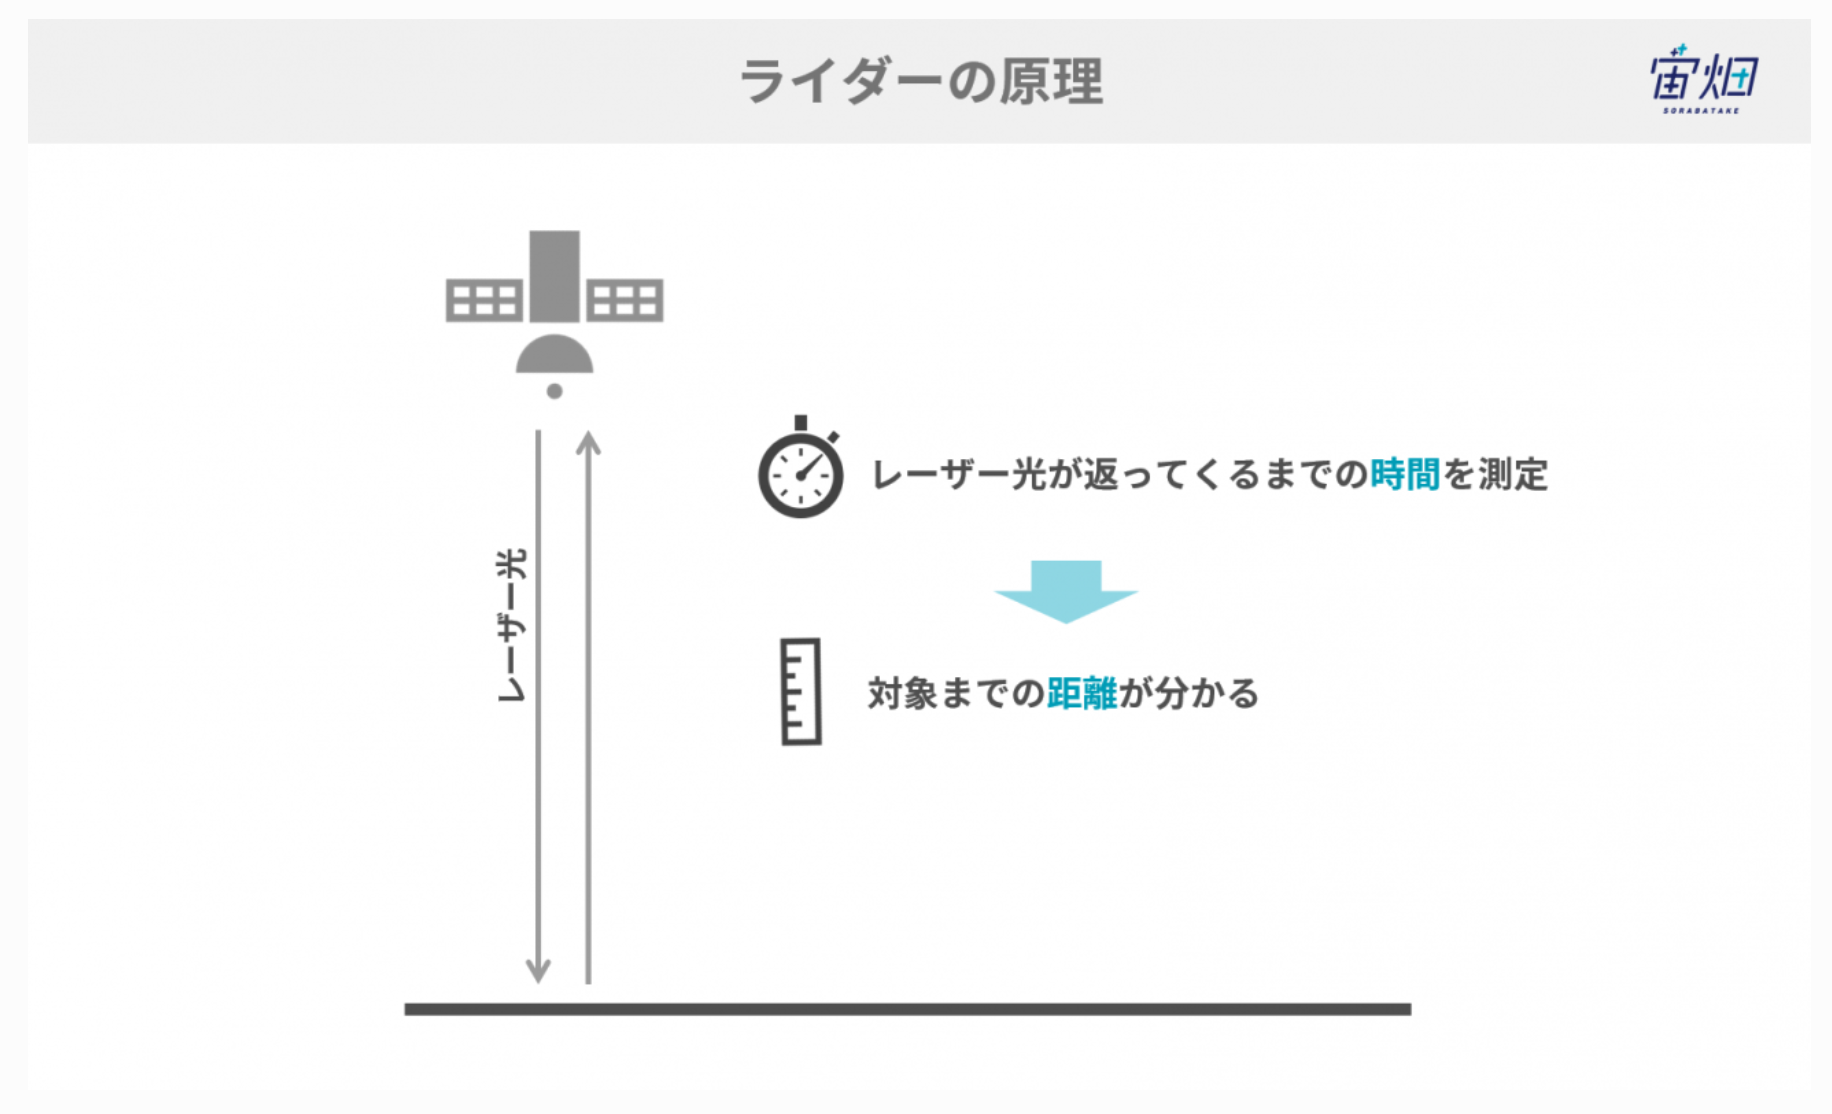

出典：https://sorabatake.jp/14216/

## GeoTransformation

ラスターデータの座標を特定の地理座標（CRS）に関連づける。

つまり、ラスターデータの原点（x0, y0）、ピクセルサイズ（X, Y）、回転方向（２方向）の６つのパラメータを変換することになる。

### Affine変換

  画像の拡大縮小(scale)、回転(rotate)、平行移動(translate)、スキュー(skew)などを行列を使って座標を変換する事。
  
  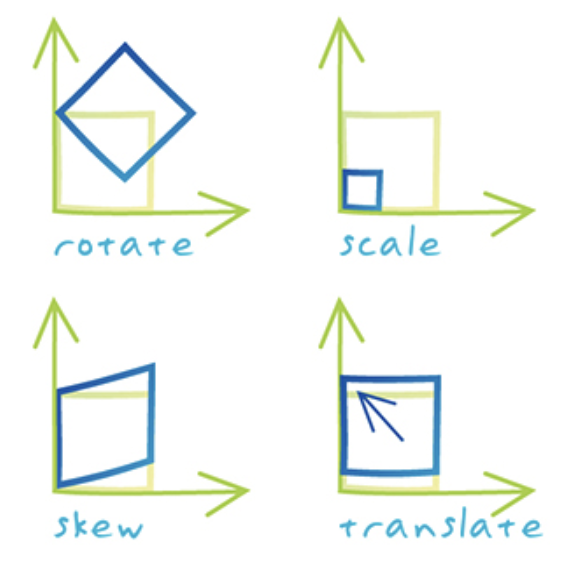
  
  出典：https://support.esri.com/ja/other-resources/gis-dictionary/term/3526be0c-e296-4c90-bb07-8a8cb121f693
  

## データ形式

ラスターデータの形式は山ほど存在する。

https://gdal.org/drivers/raster/index.html

共通しているのは

- CRS（座標参照系）の情報があること
- GeoTransformation情報（範囲や解像度）が定義されていること
- 欠損データを表す値が統一されていること


## GeoTIFF

最も一般的なラスターデータ。拡張子は `.tiff`。通常のTIFFデータに空間メタデータ（上記のGeoTransormation情報とCRS情報）が属性として埋め込まれている。


## 外部メタデータ

衛星データは多数のメタデータが存在し、衛星データ自体の外で管理されていることが一般的。例えば、衛星データの生成に使われたソフトウェア、取得した衛星、取得した日時など。

NASAはCMRというシステムで長年衛星データのメタデータを管理してきた。しかし、衛星データのユーザーとしてはCMRの全てのメタデータは必要なく、検索や品質の確保に使えれば十分。そのため [STAC](https://stacspec.org/en) というメタデータの形式が定義され、ユーザーがよく使うメタデータを使いやすくまとめている。


## GDAL（Geospatial Data Abstraction Library）

[GDAL](http://gdal.org/) はラスターデータの扱うための標準ライブラリ。

データの読み込み、書き込み、変換、検索などができる。

In [2]:
!gdalinfo --version

GDAL 3.6.0dev-e10d39568c6ab37077f4b6bc2ee3fb93e1e4d41e, released 2022/06/28


In [4]:
# GDALがサポートしているラスターデータ形式の一覧が表示される
!gdalinfo --formats

Supported Formats:
  VRT -raster,multidimensional raster- (rw+v): Virtual Raster
  DERIVED -raster- (ro): Derived datasets using VRT pixel functions
  GTiff -raster- (rw+vs): GeoTIFF
  COG -raster- (wv): Cloud optimized GeoTIFF generator
  NITF -raster- (rw+vs): National Imagery Transmission Format
  RPFTOC -raster- (rovs): Raster Product Format TOC format
  ECRGTOC -raster- (rovs): ECRG TOC format
  HFA -raster- (rw+v): Erdas Imagine Images (.img)
  SAR_CEOS -raster- (rov): CEOS SAR Image
  CEOS -raster- (rov): CEOS Image
  JAXAPALSAR -raster- (rov): JAXA PALSAR Product Reader (Level 1.1/1.5)
  GFF -raster- (rov): Ground-based SAR Applications Testbed File Format (.gff)
  ELAS -raster- (rw+v): ELAS
  ESRIC -raster- (rov): Esri Compact Cache
  AIG -raster- (rov): Arc/Info Binary Grid
  AAIGrid -raster- (rwv): Arc/Info ASCII Grid
  GRASSASCIIGrid -raster- (rov): GRASS ASCII Grid
  ISG -raster- (rov): International Service for the Geoid
  SDTS -raster- (rov): SDTS Raster
  DTED -raster- 

### データの検索と情報表示

In [10]:
HOST = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1'
IMAGE = 'LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

In [14]:
!gdalinfo /vsicurl/$HOST/$IMAGE

ERROR 11: HTTP response code: 404
gdalinfo failed - unable to open '/vsicurl/http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'.


### データ形式の変換

In [18]:
!gdal_translate -of VRT /vsicurl/$HOST/$IMAGE LC08_L1TP_042034_20170616_20170629_01_T1_B4.vrt

ERROR 11: HTTP response code: 404


In [17]:
!gdalinfo LC08_L1TP_042034_20170616_20170629_01_T1_B4.vrt | grep PROJCS

ERROR 4: LC08_L1TP_042034_20170616_20170629_01_T1_B4.vrt: No such file or directory
gdalinfo failed - unable to open 'LC08_L1TP_042034_20170616_20170629_01_T1_B4.vrt'.


## Rasterio

Rasterio は GDAL への「Pythonic」インターフェースを提供し、GDAL がサポートするほとんどの機能とフォーマットをサポートしている。

Numpyを利用してラスターデータを表現している。

### まずはラスターデータを生成する

In [1]:
import numpy as np

In [20]:
nx = 60
ny = 45
x = np.linspace(-4.0, 4.0, nx)
y = np.linspace(-3.0, 3.0, ny)
X, Y = np.meshgrid(x, y)

In [22]:
x.shape

(60,)

In [23]:
X.shape

(45, 60)

In [24]:
Z1 = np.exp(-2 * np.log(2) * ((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 1 ** 2)
Z2 = np.exp(-3 * np.log(2) * ((X + 0.5) ** 2 + (Y + 0.5) ** 2) / 2.5 ** 2)
Z = 10.0 * (Z2 - Z1)

In [28]:
Z.shape

(45, 60)

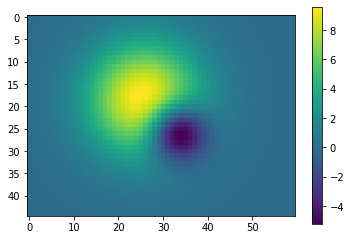

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize with matplotlib
plt.imshow(Z, origin='upper', interpolation='none')
plt.colorbar();

### Rasterioを使ってみる

- GeoTIFFファイルの作成

  下記ではgeotransformation情報とCRS情報を付与したGeoTiffファイルを保存している

In [31]:
# Create Affine geotransformation
from rasterio.transform import Affine

res = (x[-1] - x[0]) / 240.0
ulx = x[0] - res / 2
uly = y[-1] - res / 2
transform = Affine.translation(ulx, uly) * Affine.scale(res, -res)
transform

Affine(0.03333333333333333, 0.0, -4.016666666666667,
       0.0, -0.03333333333333333, 2.9833333333333334)

In [36]:
# Save as a Geotiff
import rasterio

with rasterio.open('example.tif', 'w',
                    driver='GTiff',
                    height=Z.shape[0],
                    width=Z.shape[1],
                    count=1,
                    dtype=Z.dtype,
                    crs='+proj=latlong', # this is a "proj4" string defining the projection
                    transform=transform,
                    ) as dst:
    dst.write(Z, 1)

- GeoTIFFファイルの読み込み

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 60, 'height': 45, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.03333333333333333, 0.0, -4.016666666666667,
       0.0, -0.03333333333333333, 2.9833333333333334), 'tiled': False, 'interleave': 'band'}


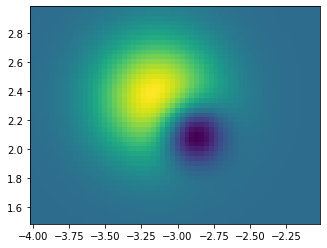

In [2]:
# Load the file into memory and plot
import rasterio.plot
with rasterio.open('example.tif') as src:
    print(src.profile)
    rasterio.plot.show(src)

- 特定の座標の値を得る

  緯度経度を指定し、numpyにおける位置を取得することで、その座標の値を確認できる

In [44]:
with rasterio.open('example.tif') as src:
    data = src.read()

In [39]:
data.shape

(1, 45, 60)

In [42]:
lon, lat = -3.33, 2.13

In [48]:
with rasterio.open('example.tif') as src:
    row, col = src.index(lon, lat)
    val = src.read(1)[row, col] # バンド1の座標データを取得しているイメージ

In [51]:
print('座標:', lon, lat, 'のデータは、行:', row, ' 列:', col, 'のデータで値は', val)

座標: -3.33 2.13 のデータは、行: 25  列: 20 のデータで値は 6.060251397244279


## Visualization?

In [5]:
!pip install ipyleaflet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 KB 17.9 MB/s eta 0:00:00


In [6]:
import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

import ipywidgets
import datetime
import re

In [8]:
bbox = [43.16, -11.32, 43.54, -11.96]
west, north, east, south = bbox
bbox_ctr = [0.5*(north+south), 0.5*(west+east)] # centerを設定

NASAのGIBS（WMTSサービス=Web Map Tile Service）を使ってタイル化されたデータとして可視化できる

ipyleafletを使ってGIBSのデータセットを検索でき、ここではMODISのTRUEカラーイメージを取得する

In [22]:
# Leafletのマップを初期化
m = Map(center=bbox_ctr, zoom=6)

In [23]:
# 左下と右上を設定することでRectangleを作れる
rectangle = Rectangle(bounds=((south, west), (north, east)))

In [24]:
# basemapsを使ってGIBSのデータを取得できる
right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, '2019-04-25')
right_layer

TileLayer(attribution='Imagery provided by services from the Global Imagery Browse Services (GIBS), operated b…

In [25]:
left_layer = TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
control

SplitMapControl(left_layer=TileLayer(options=['attribution', 'bounds', 'detect_retina', 'max_native_zoom', 'ma…

In [26]:
m.add_control(control)
m.add_layer(rectangle)
m

Map(center=[-11.64, 43.349999999999994], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

レクチャーはここで終わっていて、可視化まで至っていない、、、

4-landsat8.ipynb以降のnotebookは古いライブラリを利用しているので参考にしない。

## USGSのデータ読み込み

usgsのGUIでダウンロードしてきたデータをrasterioで表示させているだけの例

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7621, 'height': 7771, 'count': 1, 'crs': CRS.from_epsg(32652), 'transform': Affine(30.0, 0.0, 484485.0,
       0.0, -30.0, 3787515.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


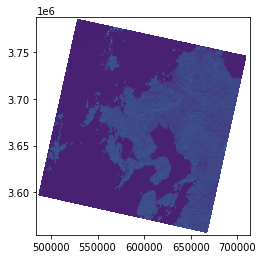

In [3]:
# Load the file into memory and plot
import rasterio.plot
with rasterio.open('usgs/LC08_L2SP_113037_20211120_20211130_02_T1_SR_B2.TIF') as src:
    print(src.profile)
    rasterio.plot.show(src)